# Capstone Project : The Battle of Neighborhood | Finding a Better Place in North York, Toronto

### 1. Installing and Importing Python Libraries

In [1]:
!pip install geocoder
!pip install folium

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 98 kB 9.1 MB/s  eta 0:00:01
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |██████████████████

Let's import the required Libraries

In [2]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup
import getpass , sys

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")


All Required Libraries Imported!


## 2. Extracting and Cleaning Data

Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia Page. Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

Converting content of PostalCode HTML table as dataframe

In [4]:
table_contents=[]
table=wiki_data.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['Postalcode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df =pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [5]:
df.head()

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [7]:
# clean dataframe 
df = df[df.Borough!='Not assigned']
df = df[df.Borough!= 0]
df.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,df.shape[0]):
    if df.iloc[i][2] == 'Not assigned':
        df.iloc[i][2] = df.iloc[i][1]
        i = i+1

In [25]:
df = df.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head(20)

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [8]:
df.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,15,103
top,M6R,North York,Thorncliffe Park
freq,1,24,1


In [9]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [11]:
df.head(20)

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [12]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [13]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,15,103
top,M1L,North York,"Kensington Market, Chinatown, Grange Park"
freq,1,24,1


In [14]:
print(df_2.shape)
df_2.head()

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [15]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.709020000000066, -79.36348999999996]

In [16]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [17]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [18]:
df_2[df_2.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
57,M5G,Downtown Toronto,Central Bay Street,43.65609,-79.38493


In [19]:
df_2.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470
3,M1G,Scarborough,Woburn,43.76812,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892


In [20]:
address = 'North York, Toronto'

geolocator = Nominatim(user_agent="Coursera-capstone-project")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of North York are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of North York are 43.7543263, -79.44911696639593.


In [21]:
map_NorthYork = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NorthYork)  
    
map_NorthYork

In [22]:
address = 'North York, Toronto'

geolocator = Nominatim(user_agent="Coursera-capstone-project")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7543263, -79.44911696639593.


In [23]:
CLIENT_ID = getpass.getpass('Enter Client ID:') # your Foursquare ID
CLIENT_SECRET = getpass.getpass('Enter Client Secret') # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

Enter Client ID:········
Enter Client Secret········


In [24]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [25]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc',
       'venue.location.neighborhood', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups'],
      dtype='object')

In [26]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# 4. Nearby Venues


In [27]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,Wolfie's Deli,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",43.754875,-79.442438
2,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.754767,-79.443250
3,Orly Restaurant & Grill,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.754493,-79.443507
4,Bagel Plus,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.755395,-79.440686


# 5. Categories of Nearby Venues

In [28]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,Wolfie's Deli,Deli / Bodega,43.754875,-79.442438
2,Tim Hortons,Coffee Shop,43.754767,-79.443250
3,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507
4,Bagel Plus,Restaurant,43.755395,-79.440686


In [29]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Pizza Place                  2
Deli / Bodega                1
Middle Eastern Restaurant    1
Fried Chicken Joint          1
Mediterranean Restaurant     1
Coffee Shop                  1
Restaurant                   1
Grocery Store                1
Sushi Restaurant             1
American Restaurant          1
Name: categories, dtype: int64

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [31]:
NorthYork_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Don Mills South
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
The Danforth  East
The Danforth West, Riverdale


In [32]:
print('There are {} Uniques Categories.'.format(len(NorthYork_venues['Venue Category'].unique())))
NorthYork_venues.groupby('Neighborhood').count().head()

There are 263 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,13,13,13,13,13,13
"Alderwood, Long Branch",4,4,4,4,4,4
"Bathurst Manor, Wilson Heights, Downsview North",1,1,1,1,1,1
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23


## One Hot Encoding of Features

In [33]:
# one hot encoding
NorthYork_onehot = pd.get_dummies(NorthYork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NorthYork_onehot['Neighborhood'] = NorthYork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NorthYork_onehot.columns[-1]] + list(NorthYork_onehot.columns[:-1])
NorthYork_onehot = NorthYork_onehot[fixed_columns]
NorthYork_grouped = NorthYork_onehot.groupby('Neighborhood').mean().reset_index()
NorthYork_onehot.head(5)

,Yoga Studio,Accessories Store,Adult Boutique,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Summer Camp,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [34]:
num_top_venues = 5
for hood in NorthYork_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =NorthYork_grouped[NorthYork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                   venue  freq
0     Chinese Restaurant  0.15
1       Sushi Restaurant  0.08
2           Skating Rink  0.08
3  Vietnamese Restaurant  0.08
4   Hong Kong Restaurant  0.08


---- Alderwood, Long Branch ----
                             venue  freq
0                              Pub  0.25
1                Convenience Store  0.25
2            Performing Arts Venue  0.25
3                              Gym  0.25
4  Molecular Gastronomy Restaurant  0.00


---- Bathurst Manor, Wilson Heights, Downsview North ----
                             venue  freq
0                     Home Service   1.0
1                      Yoga Studio   0.0
2  Molecular Gastronomy Restaurant   0.0
3                      Music Venue   0.0
4                           Museum   0.0


---- Bayview Village ----
                        venue  freq
0                       Trail  0.50
1                        Park  0.25
2  Construction & Landscaping  0.25
3                 Music Venue  0.00

           venue  freq
0    Yoga Studio  0.17
1   Skating Rink  0.17
2   Tennis Court  0.17
3           Park  0.17
4  Grocery Store  0.17


---- North Park, Maple Leaf Park, Upwood Park ----
              venue  freq
0             Trail   0.2
1     Deli / Bodega   0.2
2  Basketball Court   0.2
3              Park   0.2
4            Bakery   0.2


---- North Toronto West ----
         venue  freq
0         Park  0.33
1   Playground  0.33
2     Gym Pool  0.33
3  Yoga Studio  0.00
4  Music Venue  0.00


---- Northwood Park, York University ----
                    venue  freq
0             Coffee Shop  0.09
1  Furniture / Home Store  0.09
2                     Bar  0.09
3             Pizza Place  0.09
4    Fast Food Restaurant  0.09


---- Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East ----
                venue  freq
0         Flower Shop  0.14
1         Coffee Shop  0.14
2  Chinese Restaurant  0.14
3

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Most Common venues near neighborhood

In [36]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NorthYork_grouped['Neighborhood']

for ind in np.arange(NorthYork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NorthYork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Discount Store,Vietnamese Restaurant,Supermarket,Grocery Store,Sushi Restaurant,Bakery,Hong Kong Restaurant,Skating Rink
1,"Alderwood, Long Branch",Performing Arts Venue,Gym,Convenience Store,Pub,Women's Store,Elementary School,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Home Service,Women's Store,Escape Room,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant
3,Bayview Village,Trail,Construction & Landscaping,Park,Women's Store,Elementary School,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Pet Store,Indian Restaurant,Pharmacy,Cupcake Shop,Pub,Café,Butcher


## K-Means Clustering Approach

In [37]:
# Using K-Means to cluster neighborhood into 3 clusters
NorthYork_grouped_clustering = NorthYork_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(NorthYork_grouped_clustering)
kmeans.labels_

array([0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0,
       0, 2, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2], dtype=int32)

In [38]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NorthYork_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NorthYork_merged = NorthYork_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

NorthYork_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662,0,Fast Food Restaurant,Women's Store,Fish & Chips Shop,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room,Elementary School
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,0,Bar,Women's Store,Dog Run,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Event Space,Ethiopian Restaurant,Escape Room
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17470,2,Construction & Landscaping,Gym / Fitness Center,Park,Women's Store,Elementary School,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
3,M1G,Scarborough,Woburn,43.76812,-79.21761,2,Construction & Landscaping,Business Service,Coffee Shop,Park,Women's Store,Elementary School,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,M1H,Scarborough,Cedarbrae,43.76944,-79.23892,0,Trail,Gaming Cafe,Elementary School,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Women's Store,Distribution Center


## Map of Clusters

In [39]:
kclusters = 10

In [40]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(NorthYork_merged['Latitude'], 
                                   NorthYork_merged['Longitude'], 
                                   NorthYork_merged['Neighborhood'], 
                                   NorthYork_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [41]:
df1=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 0,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]
df2=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 1,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]
df3=NorthYork_merged.loc[NorthYork_merged['Cluster Labels'] == 2,NorthYork_merged.columns[[2] + list(range(5, NorthYork_merged.shape[1]))]]

In [42]:
NorthYork_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

In [43]:
NorthYork_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

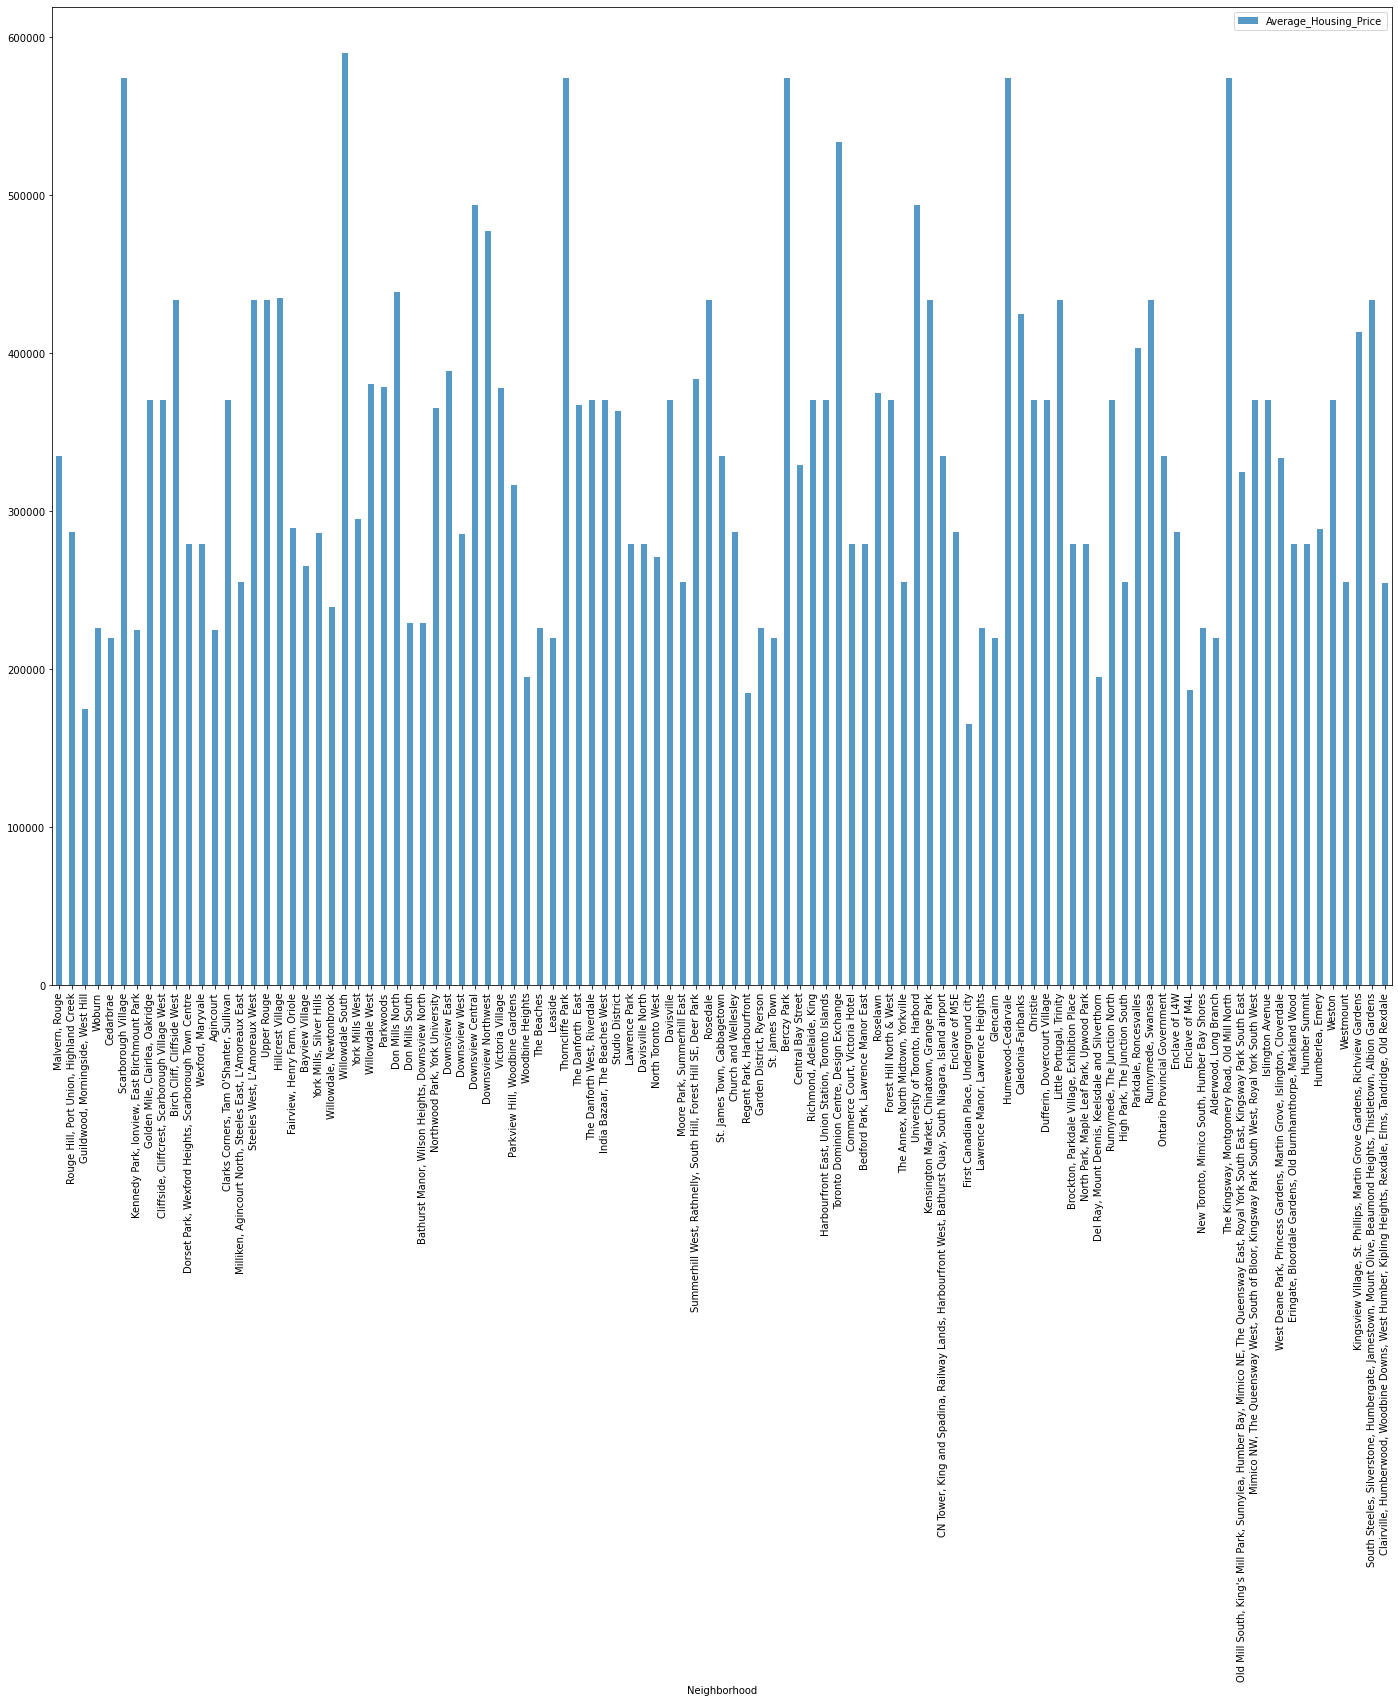

In [44]:
NorthYork_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

## School Rating by Clusters

In [45]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [46]:
new_NorthYork = NorthYork_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
NorthYork_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [47]:
NorthYork_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

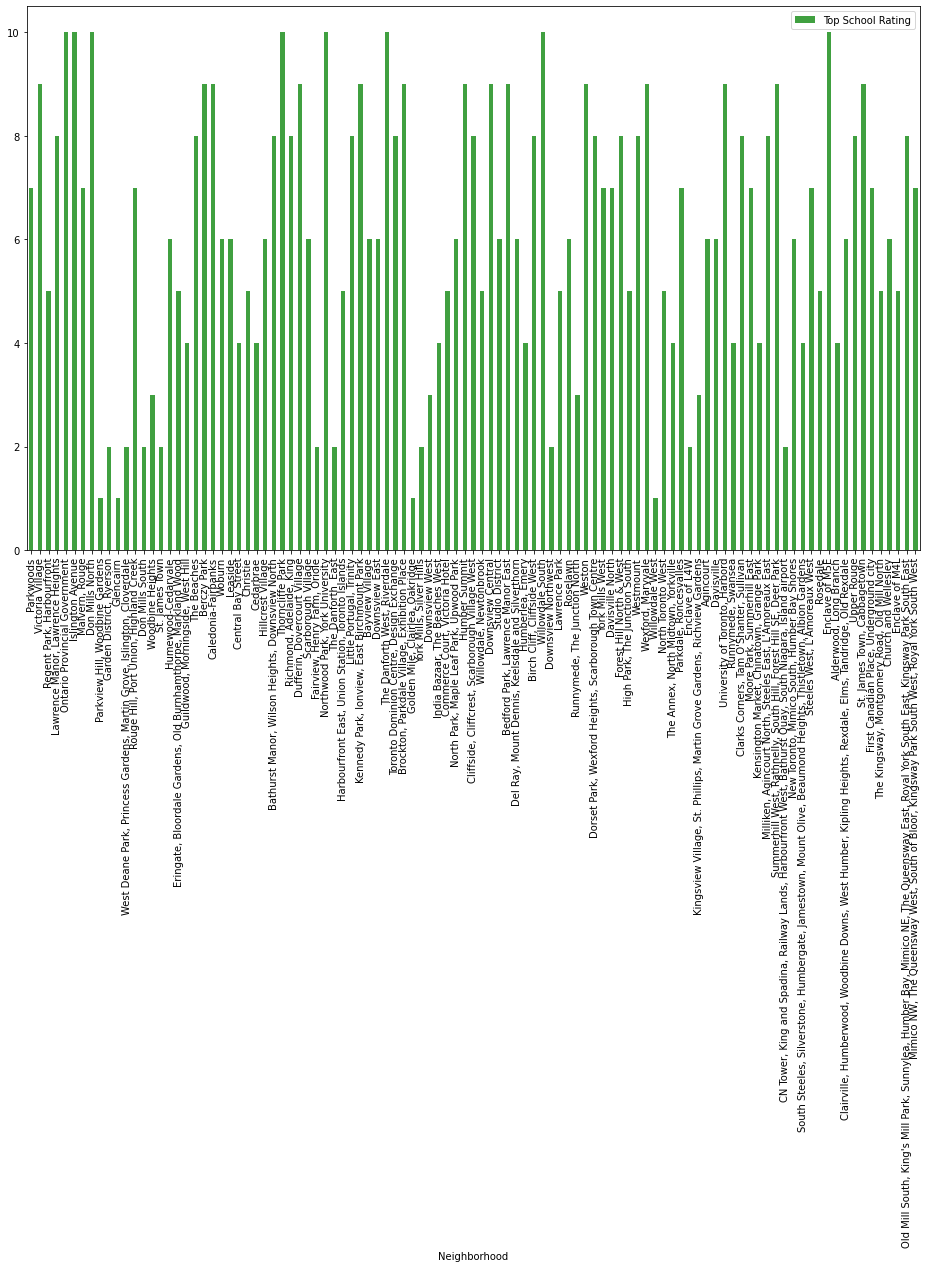

In [48]:
NorthYork_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into different clusters and different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.